# APLICAÇÃO 1
Em um mundo cada vez mais orientado por dados, a análise de conteúdo extraído de páginas web desempenha um papel crucial na compreensão das tendências, interesses e comportamentos online. A partir de uma busca no google é possível compor uma gama de informações gigantescas relacionadas ao assunto: principais portais envolvidos com a propagação da informação (g1, revistas acadêmicas, sites comerciais, etc), qual a frequência e volume de publicações sobre o assunto, principais palavras indexadas.

Essa abordagem não apenas capacita a análise de dados em tempo real, mas também alimenta um ciclo contínuo de aprendizado, onde as informações mais recentes da web são integradas em sistemas de IA, melhorando sua precisão e relevância. A exploração das principais palavras de páginas de alto impacto no Google, portanto, é uma prática poderosa para aqueles que buscam se manter à frente nas áreas de pesquisa, desenvolvimento de conteúdo, e inovação tecnológica.

No presente Notebook vamos extrair os textos contidos nos sites indexados pela primeira página de busca do google e a príncipio avaliar se há uma grande diferença em avaliar as palavras apenas pela contagem de frequência ou a partir da TF-IDF (Term Frequency-Inverse Document Frequency), uma técnica de processamento em NLP.

In [1]:
%load_ext autoreload
%autoreload 2
from func_webscrapping import busca_google, seleciona_atr, cria_soup, extrair_texto_limpo, remove_stopwords, verificar_texto_legivel
from bs4 import BeautifulSoup

import nltk
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import TfidfVectorizer

# Requisição dos conteúdos textos por webscrapping

In [2]:
# Exemplo de aplicação:
busca_soup = busca_google("convolutional network")

links_indexados = seleciona_atr(busca_soup,selecao= "div.yuRUbf>div>span>a", atr ="href") # links encontrados na primeira página da busca

soups_links = [] # Lista de objetos soups originados a partir dos links indexados na busca
for link in links_indexados:
    soup_aux = cria_soup(link)
    # Verifica se 'soup_aux' é do tipo BeautifulSoup e se sim adiciona ele na lista 
    if isinstance(soup_aux, BeautifulSoup):
        soups_links.append(soup_aux)

# Exibe o número de páginas capazes de serem análisadas
print(f"\nSoups encontrados: {len(soups_links)}\n") 

conteudos = [] # Lista contendo strings com o conteúdo texto das páginas
for soup_link in soups_links:
    # Extrai o texto do que tem maior chance de ser conteúdo das páginas
    texto = extrair_texto_limpo(soup_link) 
    
    # Verifica se o texto é legivel verificar_texto_legivel(texto)
    if verificar_texto_legivel(texto):
        
        # Aplica funções do NLTK para remover stopword em português
        texto_processado = remove_stopwords(texto)
        texto_processado = remove_stopwords(texto_processado, idioma = "english")
        
        # Define o mínimo de caracters para que o conteúdo seja definido como útil
        if len(texto_processado) > 500: 
            conteudos.append(texto_processado)
            
# Exemplo de texto coletado:
print(f"\nTexto de exemplo:\n {conteudos[0][0:150]} ...")

Search:  https://www.google.com/search?q=convolutional+network

Soups encontrados: 7


Texto de exemplo:
 convolutional neural network wikipedia jump content wikipedia free encyclopedia artificial neural network uses see cnn disambiguation article needs ad ...


# Aplicação das análises

## Frequência das palavras

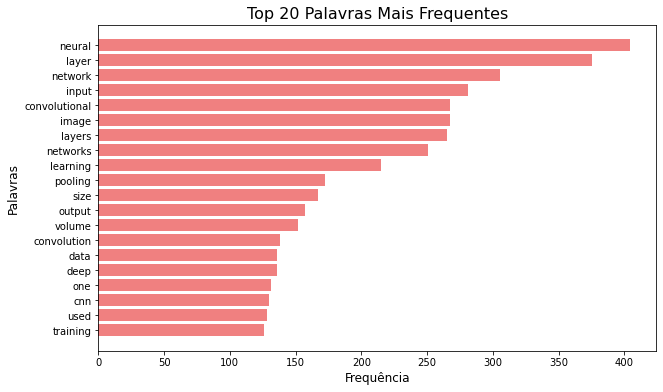

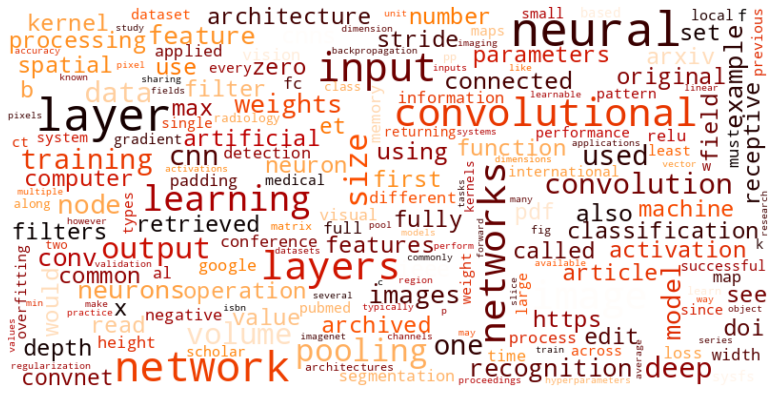

In [3]:
# Vamos transformar todos os textos em um único para analisar de forma total
textos = ""
for conteudo in conteudos:
    for palavra in conteudo.split():
        textos+= " " + palavra
        
# Para fazer a contagem das frequências das palavras precisamos tokenizar o texto e podemos usar 'word_tokenize'
palavras = nltk.word_tokenize(textos)

# Filtrar as palavras removendo qualquer caractere de pontuação
palavras = [palavra for palavra in palavras if palavra.isalpha()]

# Contar a frequência das palavras
word_freq = Counter(palavras)

def plot_horizontal_bar_frequencies(word_freq, top_n=20):
    most_common = word_freq.most_common(top_n)[::-1]
    
    words, frequencies = zip(*most_common)

    # Plotando o gráfico de barras horizontais
    plt.figure(figsize=(10, 6))
    plt.barh(words, frequencies, color='lightcoral')
    plt.xlabel('Frequência', fontsize = 12)
    plt.ylabel('Palavras', fontsize = 12)
    plt.title(f'Top {top_n} Palavras Mais Frequentes', fontsize = 16)
    plt.show()
    
def plot_wordcloud(word_freq, max_words = 100, colormap='gist_heat'):
       
    # Gera a nuvem de palavras
    wordcloud = WordCloud(width=800,
                          height=400,
                          colormap=colormap,
                          max_font_size=50, 
                          max_words=max_words,
                          background_color="white").generate_from_frequencies(word_freq)
    
    # Exibe a nuvem de palavras
    plt.figure(figsize=(14, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    #plt.title('Nuvem de Palavras')
    plt.show()

# Plot de Frequências
plot_horizontal_bar_frequencies(word_freq)

# Aplicando a nuvem as frequências que encontramos
plot_wordcloud(word_freq, max_words = 200)

# Cálculos NLP
Aqui vou fazer uso de algumas métricas para avaliar a diferença entre os resultados encontrados pela frequência simples e a partir do TD-IDF dos conteúdos encontrados.  
O TF-IDF (_Term Frequency-Inverse Document Frequency_) é uma técnica utilizada em NLP para avaliar a importância de uma palavra em um documento em relação a um corpus de documentos. O TF-IDF combina:
- **Frequência do termo (TF):** Quanto mais vezes uma palavra aparece em um documento, maior é seu TF.
- **Frequência inversa do documento (IDF):** Palavras que aparecem em muitos documentos têm um IDF menor, enquanto as que aparecem em poucos documentos têm um IDF maior.

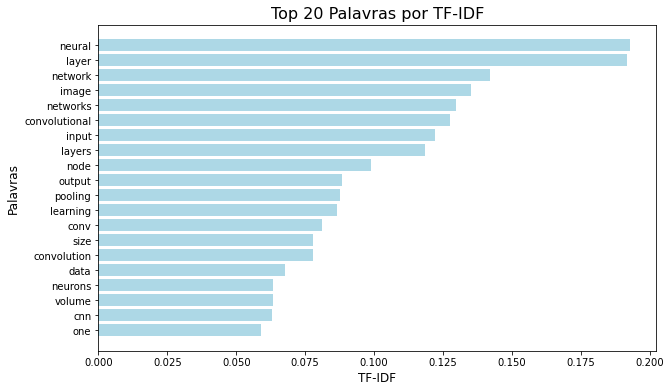

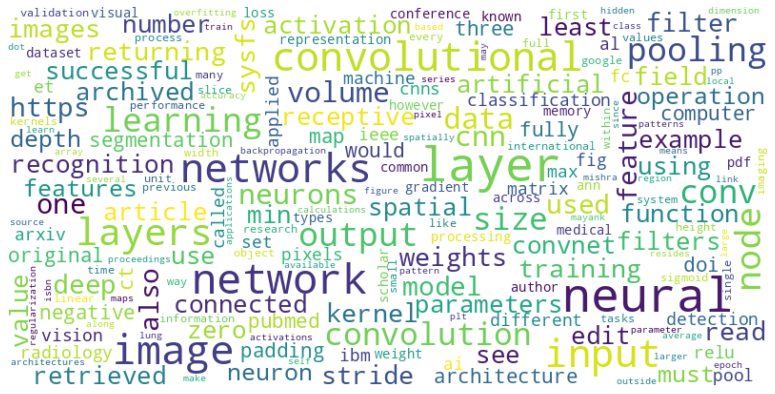

In [4]:
def plot_horizontal_bar_tfidf(word_tfidf, top_n=20):
    # Ordena o dicionário por valor (escor TF-IDF) em ordem decrescente e seleciona os top_n itens
    sorted_items = sorted(word_tfidf.items(), key=lambda x: x[1], reverse=True)[:top_n][::-1]
    
    # Desempacota as palavras e tfidf
    words, frequencies = zip(*sorted_items)

    # Plotando o gráfico de barras horizontais
    plt.figure(figsize=(10, 6))
    plt.barh(words, frequencies, color='lightblue')
    plt.xlabel('TF-IDF', fontsize = 12)
    plt.ylabel('Palavras', fontsize = 12)
    plt.title(f'Top {top_n} Palavras por TF-IDF', fontsize = 16)
    plt.show()
    
# Inicializa o vetor TF-IDF
vectorizer = TfidfVectorizer()

# Calcula TF-IDF para os documentos, nesse caso nossa "conteudos" possui o texto de cada um dos sites separados
tfidf_matrix = vectorizer.fit_transform(conteudos)

# Obtém os nomes dos termos
termos = vectorizer.get_feature_names_out()

#  Calcula a média dos escores TF-IDF para cada termo e transforma a matrix das médias em um array
tfidf_scores = tfidf_matrix.mean(axis=0).A1

# Condensa as palavras e seus escores em um objeto
word_tfidf = dict(zip(termos, tfidf_scores))

# Exemplo de uso
plot_horizontal_bar_tfidf(word_tfidf, top_n=20)

# Aplicando a nuvem as frequências que encontramos
plot_wordcloud(word_tfidf, max_words = 200, colormap='viridis')

# Correlação entre TF-IFD e Frequências gerais

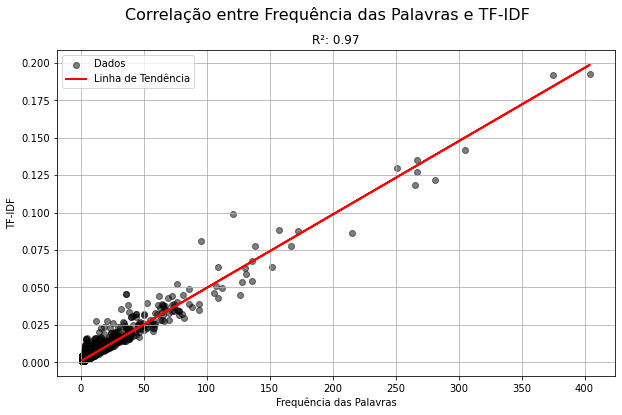

In [5]:
# Extrair palavras que estão contidas nas duas análises: frequências e TF-IDF
set_freq = set(word_freq.keys()) # Converte as chaves dos dicionários para conjuntos
set_tfidf = set(word_tfidf.keys())
words = list(set_freq & set_tfidf) # Encontra palavras comuns

common_freqs = np.array([word_freq[word] for word in words])
common_tfidf = np.array([word_tfidf.get(word, 0) for word in words])

# Calcula o coeficiente de correlação de Pearson
correlation, _ = pearsonr(common_freqs, common_tfidf)

# Ajustar a linha de tendência
model = LinearRegression()
model.fit(common_freqs.reshape(-1, 1), common_tfidf.reshape(-1, 1))
trend_line = model.predict(common_freqs.reshape(-1, 1))

# Plotando a relação entre frequências e TF-IDF com a linha de tendência
plt.figure(figsize=(10, 6))
plt.scatter(common_freqs, common_tfidf, color='black', alpha=0.5, label='Dados')
plt.plot(common_freqs, trend_line, color='red', linewidth=2, label='Linha de Tendência')
plt.xlabel('Frequência das Palavras')
plt.ylabel('TF-IDF')
plt.suptitle('Correlação entre Frequência das Palavras e TF-IDF', fontsize = 16)
plt.title(f"R²: {correlation:.2f}")
plt.legend()
plt.grid(True)
plt.show()